### Transfer Learning VGG16 unfreeze des 8 dernières couches + Augmentation de données
> Reprise du modèle entrainé pour la classification

In [1]:
%matplotlib inline
import numpy as np

import matplotlib.pyplot as plt
import cv2

import pandas as pd
from sklearn.model_selection import train_test_split

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.vgg16 import preprocess_input

from tensorflow.keras.callbacks import EarlyStopping
from sklearn import metrics
import gradcam

In [2]:
src_img = '../images_mendeley/dataset_redim/'

#### Récupération de la base d'images et création jeu d'évaluation, de test et d'entrainement

In [3]:
data = pd.read_csv('../mendeley_cells_redim.csv',index_col=0)
data_train, data_eval = train_test_split(data,test_size=0.2,random_state=123)
data_train, data_test = train_test_split(data_train,test_size=0.2,random_state=123)

#### Augmentation de données sur les données entrainement

In [4]:
train_data_generator = ImageDataGenerator(preprocessing_function=preprocess_input, rotation_range=10,width_shift_range=0.1,
                                         height_shift_range=0.1,zoom_range=0.1, horizontal_flip=True)
test_data_generator = ImageDataGenerator(preprocessing_function=preprocess_input)

train_generator = train_data_generator.flow_from_dataframe(data_train, directory=src_img, x_col='filename',y_col='category',class_mode ='sparse',target_size=(224,224),
                                              batch_size=32)

test_generator = test_data_generator.flow_from_dataframe(data_test, directory=src_img, x_col='filename',y_col='category',class_mode ='sparse',target_size=(224,224),
                                              batch_size=32)

Found 10938 validated image filenames belonging to 8 classes.
Found 2735 validated image filenames belonging to 8 classes.


In [5]:
# Création Callback pour stopper si pas stagnation
callback = EarlyStopping(monitor='val_loss', patience=2)

###### Récupération du modèle entrainé sur la classification

In [6]:
from keras.models import load_model
# load model
model = load_model('vgg16')

In [7]:
for layer in model.layers: 
    print(layer.name, layer.trainable)

vgg16 True
global_average_pooling2d_1 True
dense_4 True
dense_5 True
dense_6 True
dense_7 True


In [8]:
base_model = model.layers[0]

#### Freeze les couches de VGG16  sauf les 4 dernièrespour affiner les poids du modèle

In [9]:
# Freeze les couches VGG16, sauf les 8 dernières
for layer in base_model.layers[:-8]: 
    layer.trainable = False

In [10]:
model.compile(optimizer=Adam(learning_rate=1e-4), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
history = model.fit(train_generator, epochs = 16,batch_size = 32, validation_data = test_generator,callbacks=[callback])

Epoch 1/16
342/342 [==============================] - 6387s 19s/step - loss: 0.3736 - accuracy: 0.8872 - val_loss: 0.1207 - val_accuracy: 0.9521
Epoch 2/16
342/342 [==============================] - 6437s 19s/step - loss: 0.1394 - accuracy: 0.9561 - val_loss: 0.1013 - val_accuracy: 0.9590
Epoch 3/16
342/342 [==============================] - 6939s 20s/step - loss: 0.0840 - accuracy: 0.9718 - val_loss: 0.0960 - val_accuracy: 0.9664
Epoch 4/16
342/342 [==============================] - 6633s 19s/step - loss: 0.0789 - accuracy: 0.9777 - val_loss: 0.1164 - val_accuracy: 0.9631
Epoch 5/16
342/342 [==============================] - 6470s 19s/step - loss: 0.0639 - accuracy: 0.9791 - val_loss: 0.0955 - val_accuracy: 0.9686
Epoch 6/16
342/342 [==============================] - 6119s 18s/step - loss: 0.0660 - accuracy: 0.9781 - val_loss: 0.0644 - val_accuracy: 0.9759
Epoch 7/16
342/342 [==============================] - 6121s 18s/step - loss: 0.0514 - accuracy: 0.9842 - val_loss: 0.0873 - val_ac

In [11]:
model.save('vgg16_8_generator')

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: vgg16_8_generator\assets


#### Prédictions sur données évaluations

In [12]:
eval_generator = test_data_generator.flow_from_dataframe(data_eval, directory=src_img, x_col='filename',y_col='category',class_mode ='sparse',target_size=(224,224),
                                              batch_size=32,shuffle=False)
predict = model.predict(eval_generator)

Found 3419 validated image filenames belonging to 8 classes.


In [13]:
model.evaluate(eval_generator,batch_size=32)

107/107 [==============================] - 888s 8s/step - loss: 0.0747 - accuracy: 0.9786


[0.07467186450958252, 0.9786487221717834]

In [14]:
#Classes prédites
eval_predict_class = predict.argmax(axis = 1)
lst_classes = [key for key, val in eval_generator.class_indices.items()]
eval_predict_class_name = [lst_classes[i] for i in eval_predict_class]
eval_class_name = [lst_classes[i] for i in eval_generator.classes]
print(metrics.classification_report( eval_class_name,eval_predict_class_name ))

              precision    recall  f1-score   support

    basophil       0.96      1.00      0.98       222
  eosinophil       0.99      1.00      1.00       627
erythroblast       0.96      0.99      0.97       311
          ig       0.96      0.95      0.96       590
  lymphocyte       0.98      0.96      0.97       236
    monocyte       0.99      0.93      0.96       302
  neutrophil       0.98      0.98      0.98       682
    platelet       1.00      1.00      1.00       449

    accuracy                           0.98      3419
   macro avg       0.98      0.98      0.98      3419
weighted avg       0.98      0.98      0.98      3419



> Légère amélioration score ig et monocyte (1%)

#### GRAD CAM

In [15]:
# Reconstruit le modèle car problème de base_model avec GradCam
x = base_model.output
x = model.get_layer('global_average_pooling2d_1')(x)
x = model.get_layer('dense_4')(x)
x = model.get_layer('dense_5')(x)
x = model.get_layer('dense_6')(x)
x = model.get_layer('dense_7')(x)

In [16]:
model = Model(inputs = base_model.input, outputs = x)

In [17]:
img_size = (224, 224)
last_conv_layer_name = "block5_conv3"
# Remove last layer's softmax
model.layers[-1].activation = None

##### Basophil

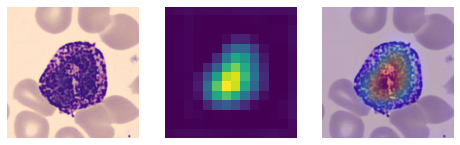

In [19]:
gradcam.display_headmap(preprocess_input, src_img + 'N_BA_200697.jpg', img_size, model, last_conv_layer_name,pred_index=0)

##### Eosinophil

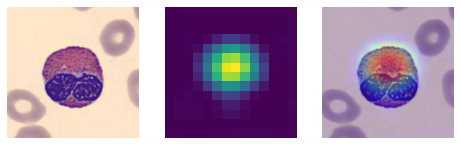

In [21]:
gradcam.display_headmap(preprocess_input, src_img + 'N_EO_40758.jpg', img_size, model, last_conv_layer_name,pred_index=1)

##### Erythroblast

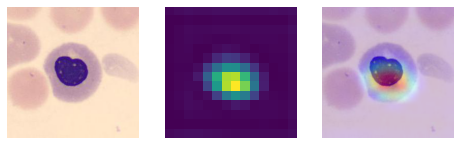

In [23]:
gradcam.display_headmap(preprocess_input, src_img + 'N_ERB_80122.jpg', img_size, model, last_conv_layer_name,pred_index=2)

##### IG

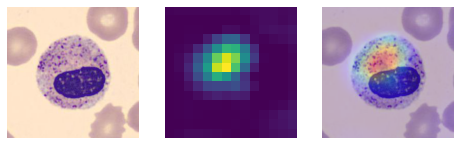

In [25]:
gradcam.display_headmap(preprocess_input, src_img + 'N_MMY_19855.jpg', img_size, model, last_conv_layer_name,pred_index=3)

##### Lymphocyte

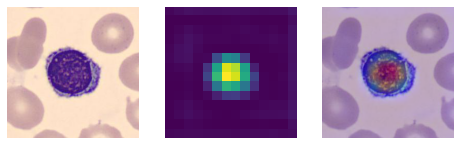

In [28]:
gradcam.display_headmap(preprocess_input, src_img + 'N_LY_99706.jpg', img_size, model, last_conv_layer_name,pred_index=4)

##### Monocyte

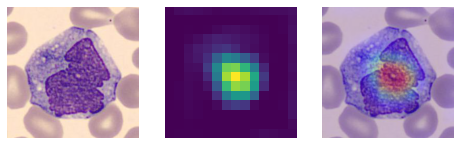

In [30]:
gradcam.display_headmap(preprocess_input, src_img + 'N_MO_60562.jpg', img_size, model, last_conv_layer_name, pred_index=5)

##### Neturophil

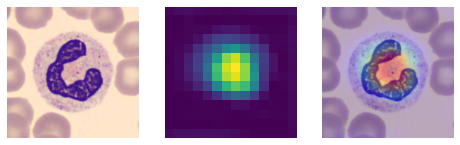

In [32]:
gradcam.display_headmap(preprocess_input, src_img + 'N_BNE_53394.jpg', img_size, model, last_conv_layer_name,pred_index=6)

##### Platelet

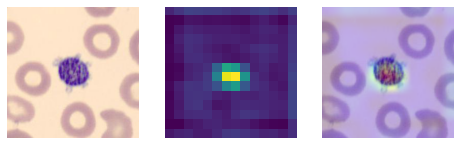

In [33]:
gradcam.display_headmap(preprocess_input, src_img + 'N_PLATELET_4736.jpg', img_size, model, last_conv_layer_name,pred_index=7)

> Pas de grande modification sur les zones utilisées

#### Matrice de confusion

In [34]:
pd.crosstab(pd.Series(eval_class_name, name='Réalité'),pd.Series(eval_predict_class_name, name='Prédiction'))

Prédiction,basophil,eosinophil,erythroblast,ig,lymphocyte,monocyte,neutrophil,platelet
Réalité,,,,,,,,
basophil,221,0,0,0,0,1,0,0
eosinophil,0,626,0,1,0,0,0,0
erythroblast,0,0,309,1,1,0,0,0
ig,7,0,6,563,1,0,13,0
lymphocyte,1,0,5,2,227,1,0,0
monocyte,2,4,0,12,2,282,0,0
neutrophil,0,0,2,9,0,0,671,0
platelet,0,0,1,1,0,0,0,447


> Confusion entre ig et monocyte

> IG prédite en neutrophil ou basophil s'explique par IG, cellules immatures neutrophil, basophil ou eosinophil